# **The Hang Seng University of Hong Kong**
# **COM3107 Machine Learning Techniques and Applications**
# **Project: Mask Detection Application**

Author: Ma Man To Tony -.-

# **Introduction**

This colab notebook is an application as a mask detector via the webcam.

Using the ResNet50 as the mask classifier and the Haar Cascade as the Face detector.

# **Part 0 - Project Preparation 0口0**

Importing package

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import PIL.ImageOps
import requests
from PIL import Image

import xml.etree.ElementTree as Xet
import pandas as pd

import matplotlib.patches as patches

import torchvision.transforms.functional as fn

Importing dataset from Kaggle

In [ ]:
#import kaggle dataset
os.environ['KAGGLE_USERNAME']='mamanto'
os.environ['KAGGLE_KEY']='e050065e9d7d4561053de58580f8c569'

! kaggle datasets download -d andrewmvd/face-mask-detection

#unzip the downloaded dataset zip file
! unzip face-mask-detection.zip

In [ ]:
#define the file locations
image_path = '/content/images/'
annotations_path = '/content/annotations/'

Trying to read the iamges and annotation files (XML)

In [ ]:
cols = ['pngName', 'name', 'xmin', 'ymin', 'xmax', 'ymax']
rows = []

#loop al xml files in annotations folder
#method from stackoverflow
#https://stackoverflow.com/questions/15679467/parse-all-the-xml-files-in-a-directory-one-by-one-using-elementtree
for filename in os.listdir(annotations_path):
  if not filename.endswith('.xml'): continue
  fullname = os.path.join(annotations_path, filename)
  xml = Xet.parse(fullname)

  pngName = xml.find('filename').text

  for object in xml.findall('object'):

    name = object.find('name').text

    xmin=object.find('bndbox').findtext('xmin')
    ymin=object.find('bndbox').findtext('ymin')
    xmax=object.find('bndbox').findtext('xmax')
    ymax=object.find('bndbox').findtext('ymax')

    #add to the rows
    rows.append({
      'pngName':pngName,
      'name':name,
      'xmin':xmin,
      'ymin':ymin,
      'xmax':xmax,
      'ymax':ymax,
    })

df = pd.DataFrame(rows, columns=cols)
#check the dataframe
print('dataframe size: ', len(df))
print(df.head(5))

Visualing the data

In [ ]:
#using the seaborn tutorial video
#https://www.youtube.com/watch?v=-7wEatT9qBg&ab_channel=PriyankaSharma
#seaborn website
#https://seaborn.pydata.org/tutorial/categorical.html
print("shape: ",df.shape)

print(df.dtypes)

import seaborn as sns
sns.countplot(data=df, x='name')

Building a function to test images and labeled them

In [ ]:
#function that plot the image with boxes locating faces
def show_mask_image(imgName):
  #save the image
  image=plt.imread(os.path.join(image_path+imgName))

  #open the xml file
  fullname = os.path.join(annotations_path+imgName[:-4]+'.xml')
  xml = Xet.parse(fullname)

  #the function that help ploting the rectangle on people faces 
  #learn from
  #https://www.geeksforgeeks.org/how-to-draw-rectangle-on-image-in-matplotlib/
  fig, ax=plt.subplots(1)
  #enlarge the image a little bit
  #learn from
  #https://www.delftstack.com/howto/matplotlib/how-to-change-the-size-and-format-of-a-figure-in-matplotlib/
  fig.set_figheight(6)
  fig.set_figwidth(8)

  for object in xml.findall('object'):
    #in each loop, it will save one of the person information in the image
    name = object.find('name').text

    xmin = object.find('bndbox').findtext('xmin')
    ymin = object.find('bndbox').findtext('ymin')
    xmax = object.find('bndbox').findtext('xmax')
    ymax = object.find('bndbox').findtext('ymax')

    #convert to integer and calculate the width and height
    #learn from
    #https://realpython.com/convert-python-string-to-int/
    x = int(xmin)
    y = int(ymin)
    w = int(xmax)-x
    h = int(ymax)-y

    print('name: '+name+', xmin: '+xmin+', ymin: '+ymin+', xmax: '+xmax+', ymax:'+ymax)

    #draw the rectangle
    #masked-> green, not masked-> red, masked wrongly-> yellow
    if (name == 'with_mask'):
      rect=patches.Rectangle((x, y),w,h,linewidth=1, edgecolor='g',facecolor="none")
      ax.add_patch(rect)

      #add the text
      #learn from
      #https://www.tutorialspoint.com/how-to-add-a-text-into-a-rectangle-in-matplotlib
      rx, ry = rect.get_xy()
      ax.annotate('OK', (rx, ry), color='green', weight='bold', fontsize=10, ha='center', va='center')

    elif (name == 'without_mask'):
      rect=patches.Rectangle((x, y),w,h,linewidth=1, edgecolor='r',facecolor="none")
      ax.add_patch(rect)

      #add the text
      rx, ry = rect.get_xy()
      ax.annotate('NOT OK', (rx, ry), color='red', weight='bold', fontsize=10, ha='center', va='center')

    elif (name == 'mask_weared_incorrect'):
      rect=patches.Rectangle((x, y),w,h,linewidth=1, edgecolor='y',facecolor="none")
      ax.add_patch(rect)

      #add the text
      rx, ry = rect.get_xy()
      ax.annotate('NOT OK', (rx, ry), color='yellow', weight='bold', fontsize=10, ha='center', va='center')

  #Last, show it
  ax.imshow(image)
  ax.add_patch(rect)

#Testing case
show_mask_image('maksssksksss402.png')
show_mask_image('maksssksksss723.png')
show_mask_image('maksssksksss834.png')

Building the dataset

In [ ]:
images=[]
labels=[]
for i in range(len(df)):
  pngFileName = df.loc[i, 'pngName']
  xmlFileName = pngFileName[:-4]+'.xml'
  xmin = int(df.loc[i, 'xmin'])
  ymin = int(df.loc[i, 'ymin'])
  xmax = int(df.loc[i, 'xmax'])
  ymax = int(df.loc[i, 'ymax'])

  #save the image
  #using the new method to import the image because the functional crop need a PIL format image
  tempImage = Image.open(image_path+pngFileName)
  #crop the image (only has the face)
  image = fn.crop(tempImage.convert('RGB'), ymin, xmin, ymax-ymin, xmax-xmin)

  #Handling the image: resize, horizontalFlip, toTensor, normalize
  resize = transforms.Resize([224, 224])
  horizontalFlip = transforms.RandomHorizontalFlip()
  ToTensor = transforms.ToTensor()
  normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

  image = resize(image)
  image = horizontalFlip(image)
  image = ToTensor(image)
  image = normalize(image)

  #save to the list
  images.append(image)

  #get the name (with_mask/without_mask/mask_weared_incorrect) and save to the label_tensor list
  #0 -> with_mask
  #1 -> without_mask
  #2 -> witmask_weared_incorrecth_mask
  name = df.loc[i, 'name']
  if name == 'with_mask':
    labels.append(torch.tensor(0))
  elif name == 'without_mask':
    labels.append(torch.tensor(1))
  elif name == 'mask_weared_incorrect':
    labels.append(torch.tensor(2))

final_dataset=[[images, labels] for images, labels in zip(images, labels)]

mydataset = tuple(final_dataset)

In [ ]:
#testing the dataset
mydataset[0]
print(len(mydataset))

Splitting the dataset

In [ ]:
#Spliting the dataset into train 70%, val 20%, test 10%
#tutorial from
#https://stackoverflow.com/questions/50544730/how-do-i-split-a-custom-dataset-into-training-and-test-datasets
train_size = int(0.7 * len(mydataset))
val_size = int(0.2 * len(mydataset))
test_size = len(mydataset) - (train_size + val_size)

train_dataset, temp_dataset = torch.utils.data.random_split(mydataset, [train_size, (val_size+test_size)])
val_dataset, test_dataset = torch.utils.data.random_split(temp_dataset, [val_size, test_size])

In [ ]:
#test the dataset size
print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

Building the dataloader

In [ ]:
#building the dataloader
from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=32, shuffle=True, num_workers=2)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=True, num_workers=2)

In [ ]:
#checking the dataloader
#Checking
train_features, train_labels = next(iter(train_dataloader))
print('train_dataloader:\nFeature batch shape: ', train_features.size(), '\nLabels batch shape: ', train_labels.size())

val_features, val_labels = next(iter(val_dataloader))
print('\nval_dataloader:\nFeature batch shape: ', val_features.size(), '\nLabels batch shape: ', val_labels.size())

test_features, test_labels = next(iter(test_dataloader))
print('\ntest_dataloader:\nFeature batch shape: ', test_features.size(), '\nLabels batch shape: ', test_labels.size())

#**Part A - Mask Classifier (Building the ResNet50 Model) 一口一**

Getting the ResNet50

In [31]:
#Getting the ResNet50 Model
resnet50 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)

Downloading: "https://github.com/pytorch/vision/archive/v0.10.0.zip" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Setting the parameter

In [32]:
#set model parameters
#https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html
for param in resnet50.parameters():
    param.requires_grad = False

Rebuilding the fc layer and checks its output channel value

In [ ]:
#showing the model detail
resnet50

In [34]:
#https://blog.csdn.net/Miaodawang/article/details/105440534
#output_channel 
output_channel = 3
input_channel = resnet50.fc.in_features

resnet50.fc = nn.Sequential(
    nn.Linear(input_channel, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, output_channel),
    nn.LogSoftmax(dim=1)
)

In [ ]:
#Check the the fc layer again
resnet50

Setting the NLLLoss, Cross Entropy, and Optimizer

In [72]:
#https://stackoverflow.com/questions/62038560/in-pytorch-what-situations-the-loss-function-need-to-inherit-nn-module
loss_func=nn.NLLLoss()
#https://www.pluralsight.com/guides/image-classification-with-pytorch
criterion=nn.CrossEntropyLoss()
#why using SGD
#https://medium.com/geekculture/a-2021-guide-to-improving-cnns-optimizers-adam-vs-sgd-495848ac6008#:~:text=One%20interesting%20and%20dominant%20argument,results%20in%20improved%20final%20performance.
optimizer = torch.optim.SGD(resnet50.parameters(), lr=0.005, momentum=0.9)

Using the CUDA~

In [9]:
#check CPU/GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

Training the ResNet50 Model

In [38]:
#RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
resnet50 = resnet50.to('cuda:0')

In [44]:
#Training
#Learning from
#https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
#https://becominghuman.ai/transfer-learning-part-5-2-implementing-resnet-in-pytorch-fe87f2821f83
epochs=50

train_losses = []
valid_losses = []

for epoch in range(epochs):
  #print('Epoch: {}/{}'.format(epoch+1, epochs))
  print(f'Epoch: {epoch+1}/{epochs}')
  print('-' * 100)

  #set to training mode
  resnet50.train()

  #loss and Accuracy within the epoch
  train_loss = 0.0
  train_accuracy = 0.0

  valid_loss = 0.0
  valid_acc = 0.0

  #iterate over data
  for i, (images, labels) in enumerate(train_dataloader):
    images = images.to(device)
    labels = labels.to(device)

    #clean existing gradients
    optimizer.zero_grad()

    #forward pass - calculate outputs on input data using the model
    outputs = resnet50(images)

    #calculate loss
    loss = criterion(outputs, labels)

    #backpropagate the gradients
    #https://stackoverflow.com/questions/62699306/runtime-error-element-0-of-tensors-does-not-require-grad-and-does-not-have-a-g
    #loss.requires_grad = True
    loss.backward()

    #update the parameters
    optimizer.step()

    #calculate the total loss
    train_loss += loss.item() * images.size(0)

    #calculate the accuracy
    ret, predictions = torch.max(outputs.data, 1)
    count = predictions.eq(labels.data.view_as(predictions))

    #convert count to float and then calculate the mean
    acc = torch.mean(count.type(torch.FloatTensor))

    #calculate total accuracy in the whole batch and add to train_acc
    train_accuracy += acc.item() * images.size(0)

    #print the batch result
    #print(f'Batch number: {i:.03d}, Training: Loss: {loss.item():.6f}, Accuracy: {acc.item():.6f}')
    print('Batch number: {:03d}, Training: Loss: {:.6f}, Accuracy: {:.6f}'.format(i, loss.item(), acc.item()))

  with torch.no_grad():

    #set to evaluation mode
    resnet50.eval()

    #validation loop
    for j, (inputs, labels) in enumerate(val_dataloader):
      inputs = inputs.to(device)
      labels = labels.to(device)

      #forward pass - calculate outputs on input data using the model
      outputs = resnet50(inputs)

      #calculate loss
      loss = criterion(outputs, labels)

      #calculate the total loss
      valid_loss += loss.item() * inputs.size(0)

      #calculate validation accuracy
      ret, predictions = torch.max(outputs.data, 1)
      count = predictions.eq(labels.data.view_as(predictions))

      #convert count to float and then calculate the mean
      acc = torch.mean(count.type(torch.FloatTensor))

      #calculate total accuracy in the whole batch and add to valid_acc
      valid_acc += acc.item() * inputs.size(0)
      print('Validation Batch number: {:03d}, Validation: Loss: {:.6f}, Accuracy: {:.6f}'.format(j, loss.item(), acc.item()))

  #Update average losses  
  train_loss = train_loss/len(train_dataloader.sampler)
  valid_loss = valid_loss/len(val_dataloader.sampler)
  train_losses.append(train_loss)
  valid_losses.append(valid_loss)

串流輸出內容已截斷至最後 5000 行。
Batch number: 072, Training: Loss: 0.145292, Accuracy: 1.000000
Batch number: 073, Training: Loss: 0.186649, Accuracy: 0.968750
Batch number: 074, Training: Loss: 0.326684, Accuracy: 0.875000
Batch number: 075, Training: Loss: 0.242615, Accuracy: 0.937500
Batch number: 076, Training: Loss: 0.312307, Accuracy: 0.875000
Batch number: 077, Training: Loss: 0.312149, Accuracy: 0.875000
Batch number: 078, Training: Loss: 0.178797, Accuracy: 0.968750
Batch number: 079, Training: Loss: 0.232085, Accuracy: 0.875000
Batch number: 080, Training: Loss: 0.167097, Accuracy: 0.968750
Batch number: 081, Training: Loss: 0.132691, Accuracy: 0.968750
Batch number: 082, Training: Loss: 0.067342, Accuracy: 0.968750
Batch number: 083, Training: Loss: 0.170029, Accuracy: 0.937500
Batch number: 084, Training: Loss: 0.426377, Accuracy: 0.875000
Batch number: 085, Training: Loss: 0.096004, Accuracy: 0.968750
Batch number: 086, Training: Loss: 0.249685, Accuracy: 0.906250
Batch number: 087, 

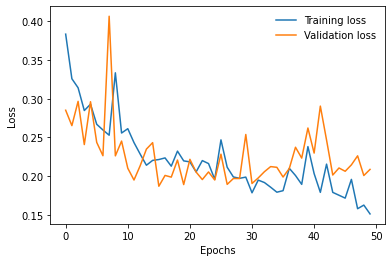

In [46]:
#plot the training and validation loss graph
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(frameon=False)

Testing the model accuracy

In [73]:
# test-the-model
#testing with the test dataloader
resnet50.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = resnet50(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
          
    print('Test Accuracy of the model: {} %'.format(100 * correct / total))

Test Accuracy of the model: 91.91176470588235 %


Saving the trained ResNet50 model if the accuracy is higher than the history accuracy percentage

In [49]:
#if the accuracy is better than before, save it
#Learning from
#https://pytorch.org/tutorials/beginner/saving_loading_models.html#:~:text=To%20load%20the%20models%2C%20first,that%20you%20must%20call%20model.
#the highest accuracy：91.91176470588235 %
torch.save(resnet50, 'resNet50Model.pth')

Testing the prediction of the trained ResNet50 model

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.96533525
with mask 有戴口罩
[[0.96533525 0.01680072 0.01786392]]


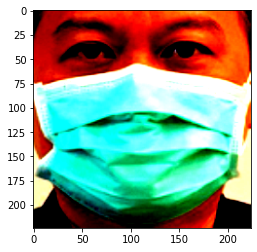

In [52]:
#this method is learning from my prof. David :) (i had altered a little bit code)
#testing with the test dataloader
images, labels = next(iter(test_dataloader))
img = images[0]
img = img.swapaxes(0, 1)
img = img.swapaxes(1, 2)
plt.imshow(img)

inputs = images.to(device)

resnet50.eval()
with torch.no_grad():
  logits = resnet50.forward(inputs[0].view(1, 3, 224, 224))
  outputLabel = torch.exp(logits).cpu().numpy()

  a = outputLabel[0, 0]
  b = outputLabel[0, 1]
  c = outputLabel[0, 2]

  list = (a, b, c)
  if (max(list)==a):
    print(a)
    status = 'with mask 有戴口罩'
  elif (max(list)==b):
    print(b)
    status = 'without mask 沒有戴口罩'
  elif (max(list)==c):
    print(c)
    status = 'masked wrongly 口罩戴錯'
  else:
    status = 'something wrong 無法計算'

  print(status)
  print(outputLabel)

# **Part B - Capturing Photo Function (Using the colab given code) =口=**

Importing the webcam function in Google Colab :D

In [4]:
#MOST all the code is JAVASCRIPT LMAO =口=
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [5]:
#Counter - it is a counter =口=
photoCounter=1

<IPython.core.display.Javascript object>

Saved to test1.png


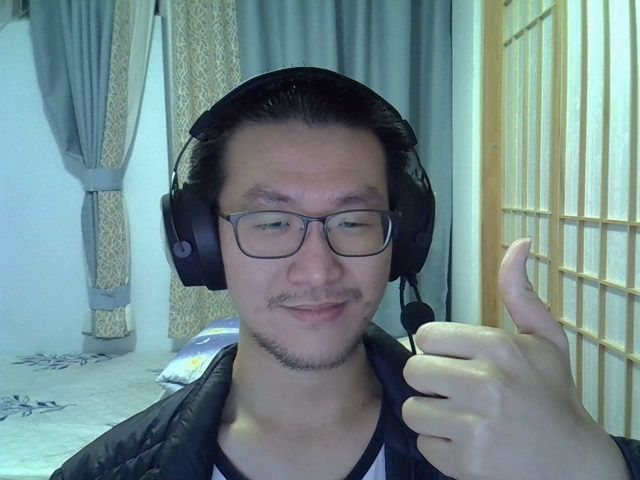

In [6]:
from IPython.display import Image
try:
  #filename='maskphoto'+str(photoCounter)
  filename = take_photo('test'+str(photoCounter)+'.png')
  print('Saved to {}'.format(filename))
  photoCounter+=1
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [7]:
#checking the current filename
print(filename)

test1.png


# **Part C - Face Detector (Using the Haar Cascade) 三口三**

Importing the Haar Cascade Classifier

In [3]:
#getting the model from github
!wget --no-check-certificate \
    https://raw.githubusercontent.com/computationalcore/introduction-to-opencv/master/assets/haarcascade_frontalface_default.xml \
    -O haarcascade_frontalface_default.xml

--2022-04-19 14:05:11--  https://raw.githubusercontent.com/computationalcore/introduction-to-opencv/master/assets/haarcascade_frontalface_default.xml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 930127 (908K) [text/plain]
Saving to: ‘haarcascade_frontalface_default.xml’

haarcascade_frontal 100%[===================>] 908.33K  --.-KB/s    in 0.05s   

2022-04-19 14:05:11 (18.8 MB/s) - ‘haarcascade_frontalface_default.xml’ saved [930127/930127]



In [4]:
#initializing the Haar Cascade face detection model
import cv2
haar_cascade_face = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

In [5]:
#altering the filename :D
filename='test1.png'

Converting the image from BGR to GRAY and testing the boxing ability

[[186 120 249 249]]


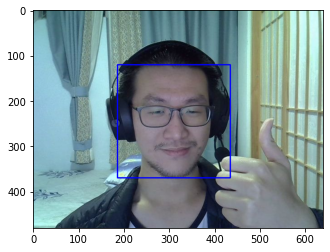

In [6]:
#using Haar Cascade and test the boxed face
test_image = cv2.imread(filename)
#Converting into GRAY (BGR to GRAY)
grey_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY)
faces = haar_cascade_face.detectMultiScale(grey_image, 1.3, 5)
print(faces)
for (x,y,w,h) in faces:
     cv2.rectangle(test_image,(x,y),(x+w,y+h),(255,0,0),2)

plt.imshow(cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB))

Cropping the photo

True

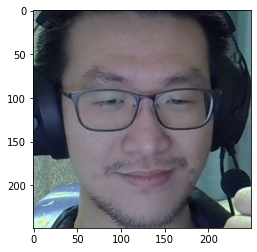

In [7]:
#from google.colab.patches import cv2_imshow
test_image = cv2.imread(filename)
faces = haar_cascade_face.detectMultiScale(grey_image, 1.3, 5)
for (x,y,w,h) in faces:
  test_image = test_image[y:y+h, x:x+w]

plt.imshow(cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB))
# Saving the image
#https://www.geeksforgeeks.org/python-opencv-cv2-imwrite-method/
cv2.imwrite(filename, test_image)

# **Part D - Image Prediction 四口四**

Loading the saved ResNet50 Model

In [10]:
#Load the saved model
model = torch.load('resNet50Model.pth')

RuntimeError: ignored

Using the ResNet50 Model to make prediction and show the result

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.9959848
without mask 沒有戴口罩
[[3.9061513e-03 9.9598479e-01 1.0912825e-04]]


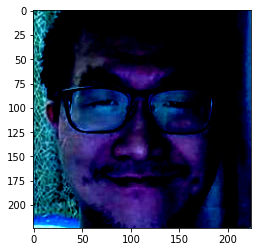

In [70]:
#reading the image
from PIL import Image
image_path='/content/'
images = Image.open('/content/'+filename).convert('RGB')

#handling the image
resize = transforms.Resize([224, 224])
images = resize(images)
ToTensor = transforms.ToTensor()
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
  
images = ToTensor(images)
images = normalize(images)

img = images
img = img.swapaxes(0, 1)
img = img.swapaxes(1, 2)
plt.imshow(img)

inputs = images.to(device)

model.eval()
with torch.no_grad():
  logits = model.forward(inputs.view(1, 3, 224, 224))
  outputLabel = torch.exp(logits).cpu().numpy()

  a = outputLabel[0, 0]
  b = outputLabel[0, 1]
  c = outputLabel[0, 2]

  list = (a, b, c)
  if (max(list)==a):
    print(a)
    status = 'with mask 有戴口罩'
  elif (max(list)==b):
    print(b)
    status = 'without mask 沒有戴口罩'
  elif (max(list)==c):
    print(c)
    status = 'masked wrongly 口罩戴錯'
  else:
    status = 'something wrong 無法計算'

  print(status)
  print(outputLabel)

# **This is the end of the application 五口五**

# **References**

**Thank you for their help :D**

*Dataset*

https://www.kaggle.com/datasets/andrewmvd/face-mask-detection


*Useful tutorial links*


https://stackoverflow.com/questions/15679467/parse-all-the-xml-files-in-a-directory-one-by-one-using-elementtree

https://www.youtube.com/watch?v=-7wEatT9qBg&ab_channel=PriyankaSharma

https://seaborn.pydata.org/tutorial/categorical.html

https://www.geeksforgeeks.org/how-to-draw-rectangle-on-image-in-matplotlib/

https://www.delftstack.com/howto/matplotlib/how-to-change-the-size-and-format-of-a-figure-in-matplotlib/

https://realpython.com/convert-python-string-to-int/

https://www.tutorialspoint.com/how-to-add-a-text-into-a-rectangle-in-matplotlib

https://stackoverflow.com/questions/50544730/how-do-i-split-a-custom-dataset-into-training-and-test-datasets

https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html

https://blog.csdn.net/Miaodawang/article/details/105440534

https://stackoverflow.com/questions/62038560/in-pytorch-what-situations-the-loss-function-need-to-inherit-nn-module

https://www.pluralsight.com/guides/image-classification-with-pytorch

https://medium.com/geekculture/a-2021-guide-to-improving-cnns-optimizers-adam-vs-sgd-495848ac6008#:~:text=One%20interesting%20and%20dominant%20argument,results%20in%20improved%20final%20performance.

https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

https://becominghuman.ai/transfer-learning-part-5-2-implementing-resnet-in-pytorch-fe87f2821f83

https://stackoverflow.com/questions/62699306/runtime-error-element-0-of-tensors-does-not-require-grad-and-does-not-have-a-g

https://pytorch.org/tutorials/beginner/saving_loading_models.html#:~:text=To%20load%20the%20models%2C%20first,that%20you%20must%20call%20model.

https://www.geeksforgeeks.org/python-haar-cascades-for-object-detection/

https://www.geeksforgeeks.org/python-opencv-cv2-imwrite-method/
